In [1]:
# imports

import numpy as np
import os
import yaml, sys
try:
    import ruamel_yaml as ry
except Exception:
    try:
        import ruamel.yaml as ry
    except Exception:
        raise ImportError('No module named ruamel.yaml or ruamel_yaml')
        

import warnings

from wisdem.inputs.validation import load_yaml, write_yaml, remove_numpy

# warnings.simplefilter('ignore', ry.yaml.error.MantissaNoDotYAML1_1Warning)


In [57]:
# Helper functions
def get_line_type(orca_yaml,type_search):
    for line_type in orca_yaml['LineTypes']:
        if line_type['Name'] == type_search:
            break
    return line_type

def get_variable_info(orca_yaml,variable_type, variable_name):
    for var in orca_yaml['VariableData'][variable_type]:
        if var['Name'] == variable_name:
            break
    return var['IndependentValue, DependentValue']


def search_type(orca_yaml,type_search,name_search):
    for instance in orca_yaml[type_search]:
        if instance['Name'] == name_search:
            break
    return instance

def print_yaml(data_struct):
    data_struct = remove_numpy(data_struct)
    yaml=ry.YAML()
    yaml.indent(mapping=4, sequence=6, offset=3)
    yaml.dump(data_struct,sys.stdout)


In [19]:

orca_input = '/Users/dzalkind/Downloads/K03 15MW semi-sub FOWT.yml'
orca_yaml = load_yaml(orca_input)


# Tower

In [4]:
platform_name = 'VolturnUS-S'

weis_tower = {}
weis_tower['outer_shape_bem'] = {}
weis_tower['internal_structure_2d_fem'] = {}



# Tower line objet
is_tower_line = [(line['Name'] == 'Tower') for line in orca_yaml['Lines']]
if not any(is_tower_line):
    raise Exception('No OrcaFlex Line objects are named "Tower".  This is required for WindIO tower information.')

tower_line = orca_yaml['Lines'][np.where(is_tower_line)[0][0]]

# Platform connection
connections = tower_line['Connection, ConnectionX, ConnectionY, ConnectionZ, ConnectionAzimuth, ConnectionDeclination, ConnectionGamma, ConnectionReleaseStage, ConnectionzRelativeTo']
# TODO: will we need to parse these multiple entries better?

is_platform_connection = [(con[0] == platform_name) for con in connections]
platform_connection = connections[np.where(is_platform_connection)[0][0]]
platform_connection_xyz = platform_connection[1:4]   # TODO: parse better later?
platform_connection_xyz

# sections = []  # Supporting only 1 section for now

tower_line_types = tower_line['LineType, Length, TargetSegmentLength']  # These are sections in orcaflex.  Not sure how we'll handle multiple. Save that for later
previous_section_height = platform_connection_xyz[2]

section = {}
section['type'] = tower_line_types[0][0]
section['length'] = tower_line_types[0][1]
type_info = get_line_type(orca_yaml,section['type'])


outer_diameter = np.array(get_variable_info(orca_yaml,'Linetypediameter','Tower OD'))  # top is 0
inner_diameter = np.array(get_variable_info(orca_yaml,'Linetypediameter','Tower ID'))  # top is 0



# It's an open question about what should be the ref axis.  Since we're sharing a reference with the inner and outer diameter, we'll use that as the reference axis for now.
# Alternative: section['z'] = np.arange(previous_section_height,line_type[1],line_type[2])
# Usign the inner/outer diameter variable info matches with the Also it matches with the IEA-15 WindIO input
# If we get different values from partners, we will want to map/interpolate to a different axis
ref_axis = {}
ref_axis['x'] = {}
ref_axis['y'] = {}
ref_axis['z'] = {}

ref_axis['z']['values'] = np.flip(outer_diameter[:,0][-1] - outer_diameter[:,0]) + platform_connection_xyz[2]  # 0 is top of tower, 129 is bottom
ref_axis['z']['grid'] = (ref_axis['z']['values'] - ref_axis['z']['values'][0]) / (ref_axis['z']['values'][-1] - ref_axis['z']['values'][0])

# X and Y follow for now
ref_axis['x']['grid'] = ref_axis['y']['grid'] = ref_axis['z']['grid']
ref_axis['x']['values'] = ref_axis['y']['values'] = np.zeros(len(ref_axis['z']['grid']))
weis_tower['outer_shape_bem']['reference_axis'] = ref_axis


weis_tower['outer_shape_bem']['outer_diameter'] = {}
weis_tower['outer_shape_bem']['outer_diameter']['grid'] = ref_axis['z']['grid']  # Shared for now, doesn't necessarily have to
weis_tower['outer_shape_bem']['outer_diameter']['values'] = np.flip(outer_diameter[:,1])  # It's not super clear what indicator OrcaFlex uses to flip these coordinates, but they definitely are flipped

# drag coefficient
weis_tower['outer_shape_bem']['drag_coefficient'] = {}
weis_tower['outer_shape_bem']['drag_coefficient']['grid'] = [0,1]
weis_tower['outer_shape_bem']['drag_coefficient']['values'] = 2*[type_info['Cdn'] / 2] # TODO: double check this one

# Internal structure
weis_tower['internal_structure_2d_fem']['reference_axis'] = ref_axis
weis_tower['internal_structure_2d_fem']['outfitting_factor'] = 1.0 # OrcaFlex is combining outfitting_factor into density
tower_layer = {}
weis_tower['internal_structure_2d_fem']['layers'] = [tower_layer]

tower_layer['name'] = 'tower_wall'
tower_layer['material'] = 'tower_material'   # TODO: fill this in from available OrcaFlex info
tower_layer['thickness'] = {}
tower_layer['thickness']['grid'] = ref_axis['z']['grid']


diameter_diff = (outer_diameter - inner_diameter)  #[:,1]
thickness = np.flip(diameter_diff[:,1] / 2)

tower_layer['thickness']['values'] = thickness

tower_material = {
  'name': 'tower_material'  ,
  'description': f'Information pulled from OrcaFlex input {orca_input}' , 
  'source': f'Information pulled from OrcaFlex input {orca_input}'   ,
  'orth': 0, # Isotropic material 
  'rho': type_info['MaterialDensity'] * 1000,  # includes outfitting_factor in WindIO, OrcaFlex in g/cm^3
  'alpha': 0  , # None in OrcaFlex
  'E': type_info['E'] * 1000  , # Different units, confirm
  'nu': type_info['PoissonRatio']  ,  # this is different between OrcaFlex and WindIO
  'G': 79.3e+009  , # Can't find in OrcaFlex
  'GIc': 0  ,  # Not used in WindIO, according to comment
  'GIIc': 0  ,  # Not used in WindIO, according to comment
  'alp0': 0  ,  # Not used in WindIO, according to comment
  'Xt': 450.e+006  , # Ultimate tensile strength (Pa), not in OrcaFlex model
  'Xc': 450.e+006  ,  # Ultimate compressive strength (Pa), not in OrcaFlex model
  'S': 0  ,  # Ultimate shear strength (Pa), not in OrcaFlex model
  'Xy': 345.e+6  , # Ultimate yield strength (Pa), not in OrcaFlex model
  'm': 3  ,  # Fatigue S/N curve fitting parameter S=A*N^(-1/m)
  'A': 3.5534648443719767e10  ,  # Fatigue S/N curve fitting parameter S=A*N^(-1/m)
  'unit_cost': 0.7  ,  # Unit cost of the material. Not in OrcaFlex model
}

# [0.0, 0.10047454902385111, 0.20094909804770222, 0.30142364707155334, 0.40189819609540445, 0.5023727451192556, 0.6028472941431067, 0.7033218431669578, 0.8037963921908089, 0.90427094121466, 1.0]


In [7]:
weis_tower = remove_numpy(weis_tower)
yaml=ry.YAML()
yaml.indent(mapping=4, sequence=6, offset=3)
# yaml.dump(weis_tower,sys.stdout)

In [6]:
weis_tower = remove_numpy(tower_material)
yaml=ry.YAML()
yaml.indent(mapping=4, sequence=6, offset=3)
yaml.dump(tower_material,sys.stdout)



name: tower_material
description: Information pulled from OrcaFlex input /Users/dzalkind/Downloads/K03
    15MW semi-sub FOWT.yml
source: Information pulled from OrcaFlex input /Users/dzalkind/Downloads/K03 15MW
    semi-sub FOWT.yml
orth: 0
rho: 8346.0
alpha: 0
E: 200000000000.0
nu: 0.261
G: 79300000000.0
GIc: 0
GIIc: 0
alp0: 0
Xt: 450000000.0
Xc: 450000000.0
S: 0
Xy: 345000000.0
m: 3
A: 35534648443.719765
unit_cost: 0.7


# Nacelle

In [79]:
# orca_yaml['6DBuoys']['Name']

orca_turbine = orca_yaml['Turbines'][0]
orca_nacelle = search_type(orca_yaml,'6DBuoys','Nacelle')

# Reduce for readability
# orca_nacelle.pop('VertexX, VertexY, VertexZ')
# orca_nacelle.pop('PanelVertexIndex1, PanelVertexIndex2, PanelVertexIndex3, PanelVertexIndex4')

orca_nacelle

ne = {}
ne["system_mass"] = orca_nacelle['Mass'] * 1000 # Mass of the nacelle system, including the entire drivetrain system (shafts, gearbox if present, break, bearings, generator). It excludes the turbine rotor, the hub, and the yaw system.
ne["yaw_mass"] =  0  # Orcaflex puts all the mass in the nacelle, not sure how this will affect OpenFAST
ne["system_inertia"] =  np.r_[orca_nacelle['MomentsOfInertia'],0,0,0] * 1000  # This needs to be length 6, orcaflex relative to center of mass
ne["system_inertia_tt"] = np.r_[orca_nacelle['MomentsOfInertia'],0,0,0] * 1000  # TODO translate this?  Is it needed?
ne["system_center_mass"] = orca_nacelle['CentreOfMass'] 

weis_nacelle = {}
weis_nacelle['elastic_properties_mb'] = ne

dt = {}
dt['uptilt'] = np.radians(orca_turbine['InitialAttitude'][1] - 90)  # TODO: check this, but this seems to be where 6 deg uptilt lives
dt['generator_inertia_user'] = 1000*orca_turbine['GeneratorInertia']
weis_nacelle['drivetrain'] = dt

dt["distance_tt_hub"] = orca_turbine['InitialPosition'][2]
dt["overhang"] = -orca_turbine['InitialPosition'][0]
dt["gear_ratio"] = orca_turbine['GeneratorGearRatio']
dt["gearbox_efficiency"] = 1.0  # OrcaFlex doesn't model efficiencies?



hub_mb = {}
hub = {}


hub['diameter'] = orca_turbine['HubRadius'] * 2
hub['cone_angle'] = np.radians(orca_turbine['PreConeAngle'])
hub['elastic_properties_mb'] = hub_mb
hub_mb['system_mass'] = orca_turbine['HubMass'] * 1000
hub_mb['system_inertia']= 1000*np.r_[orca_turbine['HubAxialMomentOfInertia'],orca_turbine['HubTransverseMomentOfInertia'],orca_turbine['HubTransverseMomentOfInertia'],0,0,0]


In [80]:
# orca_turbine

In [82]:
print_yaml(hub)

diameter: 7.94
cone_angle: 0.06981317007977318
elastic_properties_mb:
    system_mass: 69360.0
    system_inertia:
       -  973520.0
       -  619970.0
       -  619970.0
       -  0.0
       -  0.0
       -  0.0


In [ ]:
# weis_tower = remove_numpy(tower_material)
# yaml=ry.YAML()
# yaml.indent(mapping=4, sequence=6, offset=3)
# yaml.dump(tower_material,sys.stdout)

In [ ]:
type_info['E']

In [24]:
l = 144.386-15
13 / l

0.10047454902385111

In [36]:
type_info['E']

200000000.0

In [28]:
outer_diameter[:,0]

array([  0.   ,  12.386,  25.386,  38.386,  51.386,  64.386,  77.386,
        90.386, 103.386, 116.386, 129.386])

In [31]:
np.flip(outer_diameter[:,0][-1] - outer_diameter[:,0])

array([  0.   ,  13.   ,  26.   ,  39.   ,  52.   ,  65.   ,  78.   ,
        91.   , 104.   , 117.   , 129.386])

In [37]:
7800*1.07

8346.0

In [38]:
36.15/33.79

1.0698431488606097

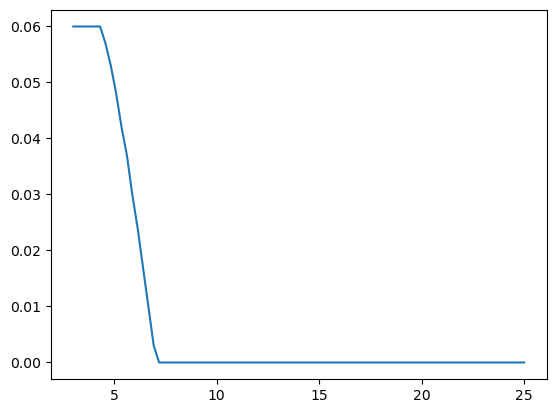

In [41]:
a = [3.000, 3.262, 3.523, 3.785, 4.047, 4.309, 4.570, 4.832, 5.094, 5.356, 5.617, 5.879, 6.141, 6.402, 6.664, 6.926, 7.188, 7.449, 7.711, 7.973, 8.234, 8.496, 8.758, 9.020, 9.281, 9.543, 9.805, 10.067, 10.328, 10.590, 11.070, 11.551, 12.031, 12.511, 12.992, 13.472, 13.952, 14.433, 14.913, 15.393 ,15.874 ,16.354, 16.834, 17.315, 17.795, 18.275, 18.756 ,19.236, 19.716 ,20.197, 20.677 ,21.157 ,21.638, 22.118, 22.598 ,23.079, 23.559 ,24.039 ,24.520, 25.000 ]

b = [0.060  ,    0.060  ,    0.060     , 0.060   ,   0.060   ,   0.060  ,    0.057   ,   0.053  ,    0.048  ,    0.042   ,   0.037   ,   0.030  ,    0.024  ,    0.017   ,   0.010   ,   0.003    ,  0.000   ,   0.000   ,   0.000   ,   0.000   ,   0.000    ,  0.000   ,   0.000   ,   0.000   ,   0.000   ,   0.000    ,  0.000   ,   0.000   ,   0.000    ,  0.000   ,   0.000   ,   0.000  ,    0.000  ,    0.000   ,   0.000   ,   0.000   ,   0.000   ,   0.000  ,    0.000    ,  0.000   ,   0.000   ,   0.000  ,    0.000  ,    0.000  ,    0.000   ,   0.000   ,   0.000   ,   0.000    ,  0.000    ,  0.000  ,    0.000   ,   0.000   ,   0.000   ,   0.000  ,    0.000  ,    0.000   ,   0.000   ,   0.000  ,    0.000  ,    0.000 ]  

import matplotlib.pyplot as plt
plt.plot(a,b)